# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Imports dependency 
import tensorflow as tf
import tensorflow.contrib.slim as slim  # TensorFlow-Slim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.cross_validation import train_test_split
import numpy as np
import cv2
import math
import os
import time
import sys
from pathlib import Path
import pickle
%matplotlib inline

/home/holman/anaconda2/envs/carND/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Settings/parameters to be used later

# Constants
IMG_SIZE = 32  # square image of size IMG_SIZE x IMG_SIZE
NUM_CHANNELS = 1 
NUM_CLASSES = 43

# Model parameters
LR = 5e-3  # learning rate
KEEP_PROB = 0.5  # dropout keep probability
OPT = tf.train.GradientDescentOptimizer(learning_rate=LR)  # choose which optimizer to use

# Training process
NUM_EPOCH = 40
BATCH_SIZE = 128  # batch size for training (relatively small)
MODEL_SAVE_PATH = './model/model.ckpt'  # where to save trained model


training_file  = "./dataset/train.p"
validation_file= "./dataset/valid.p"
testing_file   = "./dataset/test.p"
train_aug_file = "./dataset/train_aug.p"
 
#augmentation params
ANGLE_ROTATE = 25
TRANSLATION = 0.2
NB_NEW_IMAGES = 10000

In [3]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
def augmenteImage(image, angle, translation):
    h, w, c = image.shape
    
    # random rotate
    angle_rotate = np.random.uniform(-angle, angle)
    rotation_mat = cv2.getRotationMatrix2D((w//2, h//2), angle_rotate, 1)

    img = cv2.warpAffine(image, rotation_mat, (IMG_SIZE, IMG_SIZE))

    # random translation
    x_offset = translation * w * np.random.uniform(-1, 1)
    y_offset = translation * h * np.random.uniform(-1, 1)
    mat = np.array([[1, 0, x_offset], [0, 1, y_offset]])

    # return warpped img
    return cv2.warpAffine(img, mat, (w, h))

# import helper function 
class batchGenerator:
    def __init__(self, x, y, shuffle= True):
        self.dataX = x
        self.dataY = y
        self.totalData = len(self.dataX)
        if shuffle:
            self.shuffle()
    
    def printLog(self):
        if len(self.dataX):
            print(str(totalData-len(self.dataX))+"/"+str(totalData) , end = '\r')
        else:
            print(str(totalData-len(self.dataX))+"/"+str(totalData))
    
    def shuffle(self):
        newOrder = np.arange(len(self.dataX))
        np.random.shuffle(newOrder)
        self.dataX = self.dataX[newOrder]
        self.dataY = self.dataY[newOrder]
        
    def hasNext(self):
        return len(self.dataX)>0
    
    def next_batch(self,size):
        if(len(self.dataX) < size):
            size = len(self.dataX)
        tempX = self.dataX[0: size]
        self.dataX = self.dataX[size:]
        tempY = self.dataY[0: size]
        self.dataY = self.dataY[size:]
        
        return np.array(tempX), np.array(tempY) 

    
def calculate_accuracy(batch_size, accuracy, x, y, x_data, y_data, keep_prob, sess):
    """ 
        helper function to cal acc 
    """
    accs = []
    generator = batchGenerator(x_data, y_data)
    while generator.hasNext():
        x_, y_ = generator.next_batch(batch_size)
        acc = sess.run(accuracy, feed_dict={x: x_, y: y_, keep_prob: 1.})
        accs.append(acc*len(x_))
    acc_full = np.sum(accs)/len(x_data)
    return acc_full

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# the shape of an traffic sign image
image_shape = X_train[0].shape

# number of unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

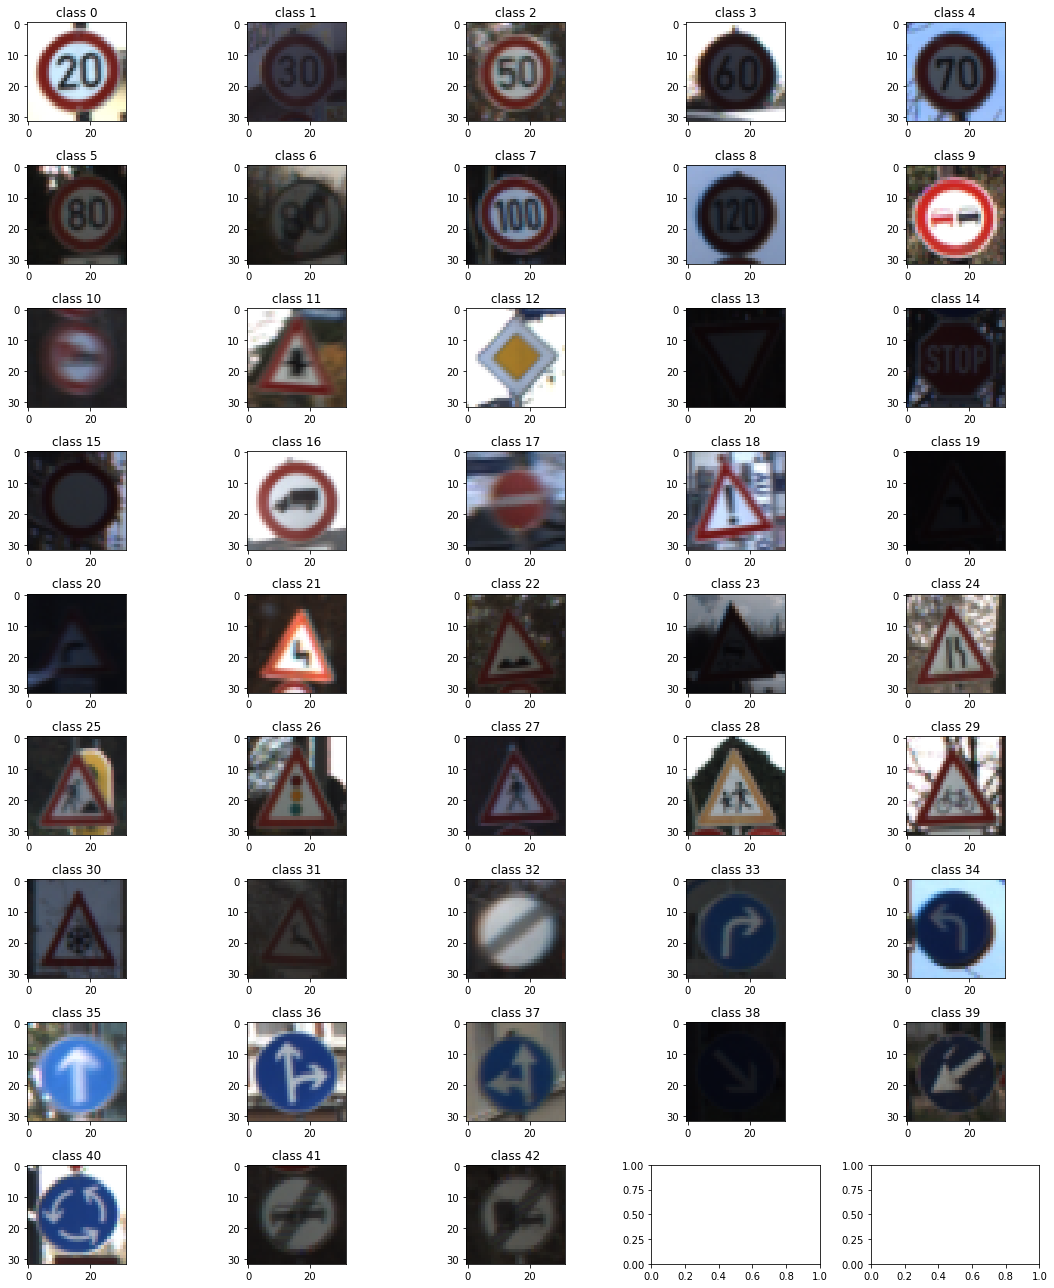

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
#edit matplot size in notebook
plt.rcParams["figure.figsize"] = [15,18]


fig = plt.figure(figsize=(5,5))
f, axarr = plt.subplots(9, 5)
# make it as a sigle dim. array
plts = np.reshape(axarr, -1)

#display one sample from all class
for classId in np.unique(y_train):
    thePicIndex = np.where(y_train == classId)[0]
    myplt = plts[classId]
    myplt.imshow(X_train[thePicIndex[25]])
    myplt.set_title("class " + str(classId))
    
plt.tight_layout()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
# data augmentation
if not Path(train_aug_file).is_file():
    with open(training_file, mode='rb') as file:
        data = pickle.load(file)
    data_x, data_y = data['features'], data['labels']

    new_data_x = np.empty((NB_NEW_IMAGES, 32, 32, 3), dtype=np.uint8)
    new_data_y = np.empty(NB_NEW_IMAGES, dtype=np.uint8)

    for i in range(NB_NEW_IMAGES):
        target = np.random.randint(data_x.shape[0])
        new_data_x[i] = augmenteImage(data_x[target], ANGLE_ROTATE, TRANSLATION)
        new_data_y[i] = data_y[target]

    X_train = np.concatenate((data_x, new_data_x))
    y_train = np.concatenate((data_y, new_data_y))
    
    new_data = {'features': X_train, 'labels': y_train}

    with open(train_aug_file, mode='wb') as file:
        pickle.dump(new_data, file)
else:    
    with open(train_aug_file, mode='rb') as f:
        train = pickle.load(f)
        X_train, y_train = train['features'], train['labels']

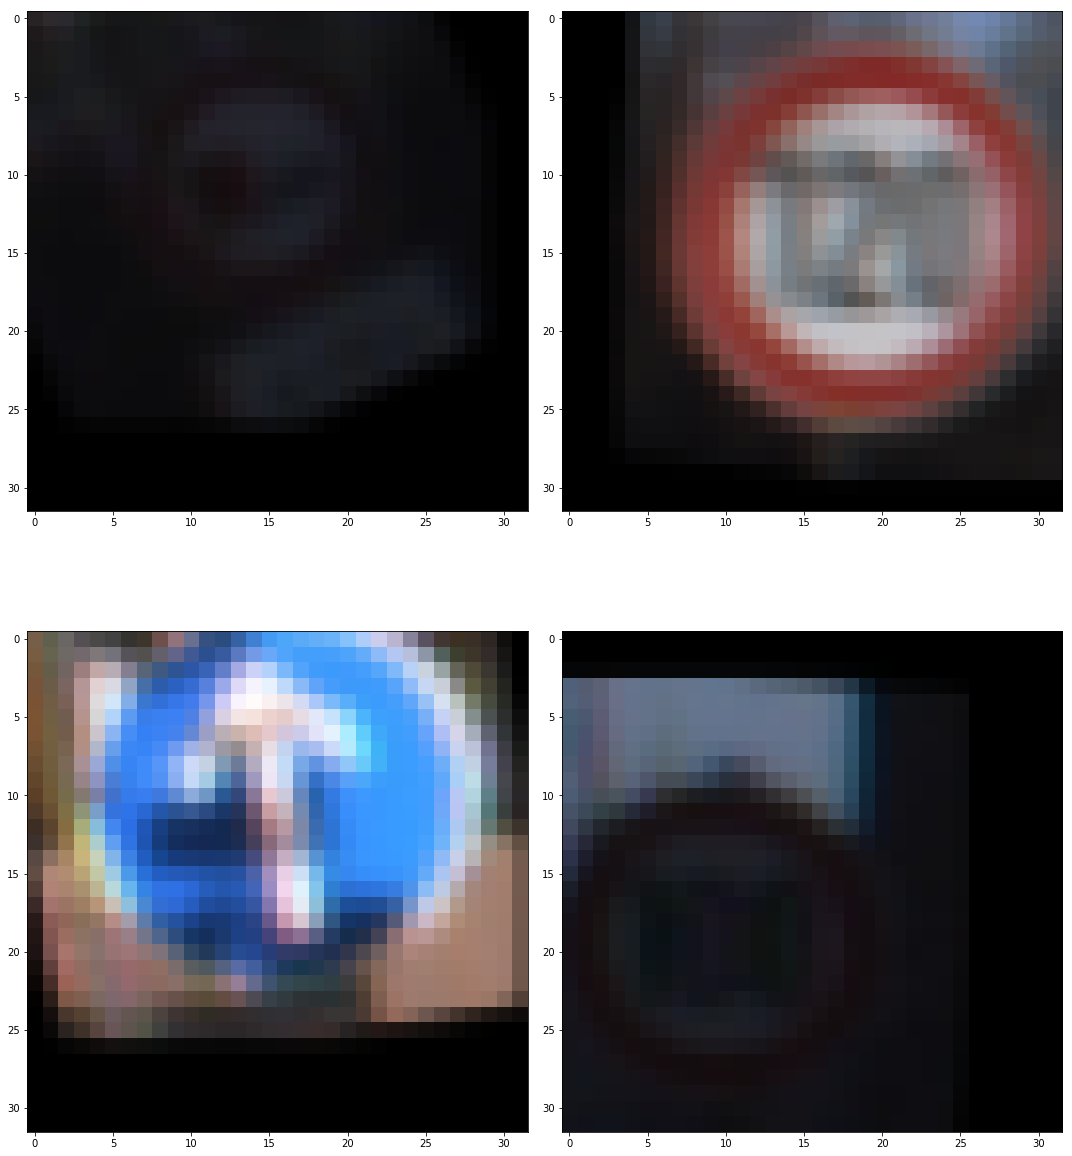

In [8]:
#plot some processed transformed images
showIds = np.random.randint(n_train, len(X_train), size=(9) )

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(X_train[showIds[i]])

    
plt.tight_layout()
plt.show()

In [11]:
### Preprocess the data here. 

# gray scale the images
def toGrayscale(rgb):
    result = np.zeros((len(rgb), 32, 32,1))
    result[...,0] = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])  
    return result

# normalize the images
def normalizeGrascale(grayScaleImages):
    return grayScaleImages/255

def processImages(rgbImages):
    return np.array(normalizeGrascale(toGrayscale(rgbImages)))

def transformOnHot(nbClass, listClass):
    oneHot = np.zeros((len(listClass), nbClass))
    oneHot[np.arange(len(listClass)), listClass] = 1
    return np.array(oneHot)

x_train_processed = processImages(X_train)
x_test_processed  = processImages(X_test)
x_valid_processed = processImages(X_valid)
y_train_processed = transformOnHot(n_classes, y_train)
y_valid_processed = transformOnHot(n_classes, y_valid)
y_test_processed  = transformOnHot(n_classes, y_test)

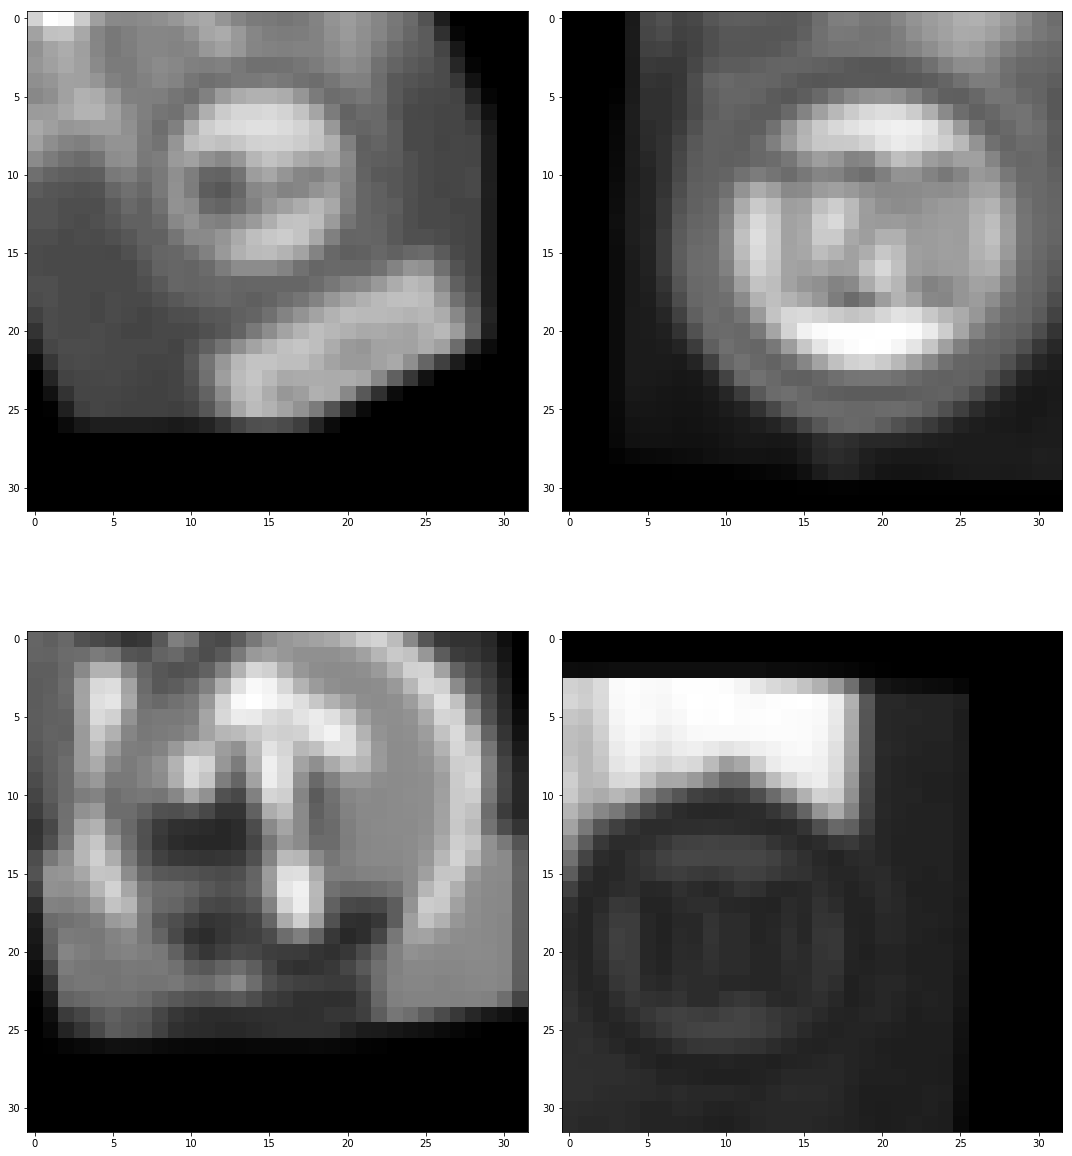

In [12]:
#plot gray scale images

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(x_train_processed[showIds[i]][:,:,0], cmap=plt.get_cmap('gray'))

    
plt.tight_layout()
plt.show()

### Model Architecture

In [13]:
def nn():
    with tf.variable_scope('neural_network'):
        # Tensors representing input images and labels
        x = tf.placeholder('float', [None, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
        y = tf.placeholder('float', [None, NUM_CLASSES])

        # Placeholder for dropout keep probability
        keep_prob = tf.placeholder(tf.float32)

        # Neural network architecture: Convolutional Neural Network (CNN)
        # Using TensorFlow-Slim to build the network:
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim

        # Use batch normalization for all convolution layers
        with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
            # Given x shape is (32, 32, 3)
            # Conv and pool layers
            net = slim.conv2d(x, 16, [3, 3], scope='conv0')  # output shape: (32, 32, 16)
            net = slim.max_pool2d(net, [3, 3], 1, padding='SAME', scope='pool0')  # output shape: (32, 32, 16)
            net = slim.conv2d(net, 64, [5, 5], 3, padding='VALID', scope='conv1')  # output shape: (10, 10, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool1')  # output shape: (8, 8, 64)
            net = slim.conv2d(net, 128, [3, 3], scope='conv2')  # output shape: (8, 8, 128)
            net = slim.conv2d(net, 64, [3, 3], scope='conv3')  # output shape: (8, 8, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool3')  # output shape: (6, 6, 64)

            # Final fully-connected layers
            net = tf.contrib.layers.flatten(net)
            net = slim.fully_connected(net, 1024, scope='fc4')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, 1024, scope='fc5')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, NUM_CLASSES, scope='fc6')

        # Final output (logits)
        logits = net

        # Loss (data loss and regularization loss) and optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y))
        optimizer = OPT.minimize(loss)
        
        # Prediction (used during inference)
        predictions = tf.argmax(logits, 1)

        # Accuracy metric calculation
        correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Return relevant tensor references
    return x, y, keep_prob, logits, optimizer, predictions, accuracy


In [14]:
def train():    
    with tf.Graph().as_default(), tf.Session() as sess:
        ## ini network
        x, y, keep_prob, logits, optimizer, predictions, accuracy = nn()

        # Dro save model
        saver = tf.train.Saver()

        # TensorBoard record 
        train_writer = tf.summary.FileWriter("tf_summary/train", sess.graph)  

        # Variable initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # For book-keeping, keep track of training and validation accuracy over epochs, like such:
        # [(train_acc_epoch1, valid_acc_epoch1), (train_acc_epoch2, valid_acc_epoch2), ...]
        accuracy_history = []


        # Record time elapsed for performance check
        last_time = time.time()
        train_start_time = time.time()

        # Run NUM_EPOCH epochs of training
        for epoch in range(NUM_EPOCH):
            generator = batchGenerator(x_train_processed, y_train_processed)
            while generator.hasNext():
                x_, y_ = generator.next_batch(32)
                sess.run(optimizer, feed_dict={x: x_, y: y_, keep_prob: KEEP_PROB})
                
            # Training set
            train_acc = calculate_accuracy(32, accuracy, x, y, x_train_processed, y_train_processed, keep_prob, sess)

            # Validation set
            valid_acc = calculate_accuracy(32, accuracy, x, y, x_valid_processed, y_valid_processed, keep_prob, sess)

            # Record and report train/validation/test accuracies for this epoch
            accuracy_history.append((train_acc, valid_acc))

            # Print accuracy every 10 epochs
            if (epoch+1) % 10 == 0 or epoch == 0 or (epoch+1) == NUM_EPOCH:
                print('Epoch %d -- Train acc.: %.4f, Validation acc.: %.4f, Elapsed time: %.2f sec' %\
                    (epoch+1, train_acc, valid_acc, time.time() - last_time))
                last_time = time.time()

        total_time = time.time() - train_start_time
        print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time/60))

        # After training is complete, evaluate accuracy on test set
        print('Calculating test accuracy...')
        test_acc = calculate_accuracy(32, accuracy, x, y, x_test_processed, y_test_processed, keep_prob, sess)
        print('Test acc.: %.4f' % (test_acc,))

        # Save model to disk
        if not os.path.exists("./model/"):
            os.makedirs("./model/")    
    
        save_path = saver.save(sess, MODEL_SAVE_PATH)
        print('Trained model saved at: %s' % save_path)

        # Also save accuracy history
        print('Accuracy history saved at accuracy_history.p')
        with open('accuracy_history.p', 'wb') as f:
            pickle.dump(accuracy_history, f)
                
    return accuracy_history
                
accuracy_history = train()

Epoch 1 -- Train acc.: 0.6025, Validation acc.: 0.5787, Elapsed time: 11.57 sec
Epoch 10 -- Train acc.: 0.9872, Validation acc.: 0.9703, Elapsed time: 99.85 sec
Epoch 20 -- Train acc.: 0.9960, Validation acc.: 0.9685, Elapsed time: 110.46 sec
Epoch 30 -- Train acc.: 0.9987, Validation acc.: 0.9776, Elapsed time: 112.39 sec
Epoch 40 -- Train acc.: 0.9990, Validation acc.: 0.9807, Elapsed time: 112.00 sec
Total elapsed time: 446.27 sec (7.44 min)
Calculating test accuracy...
Test acc.: 0.9523
Trained model saved at: ./model/model.ckpt
Accuracy history saved at accuracy_history.p


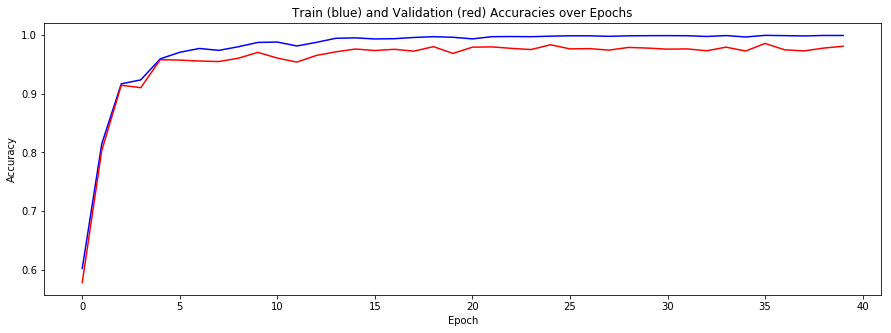

In [35]:
hist = np.transpose(np.array(accuracy_history))
plt.figure(figsize=(15,5))
plt.plot(hist[0], 'b')  # training accuracy
plt.plot(hist[1], 'r')  # validation accuracy
plt.title('Train (blue) and Validation (red) Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [25]:
# load images
imgPaths =  ['./sampleImages/' + image_file for image_file in os.listdir('sampleImages')]
imgs = []
for imgPath in imgPaths:
    img = Image.open(imgPath)
    img = img.convert('RGB')
    img = img.resize((32, 32), Image.ANTIALIAS)
    img = np.array(list(img.getdata()), dtype='uint8')
    img = np.reshape(img, (32, 32, 3))
    imgs.append(img)
imgs = np.array(imgs, dtype='uint8')

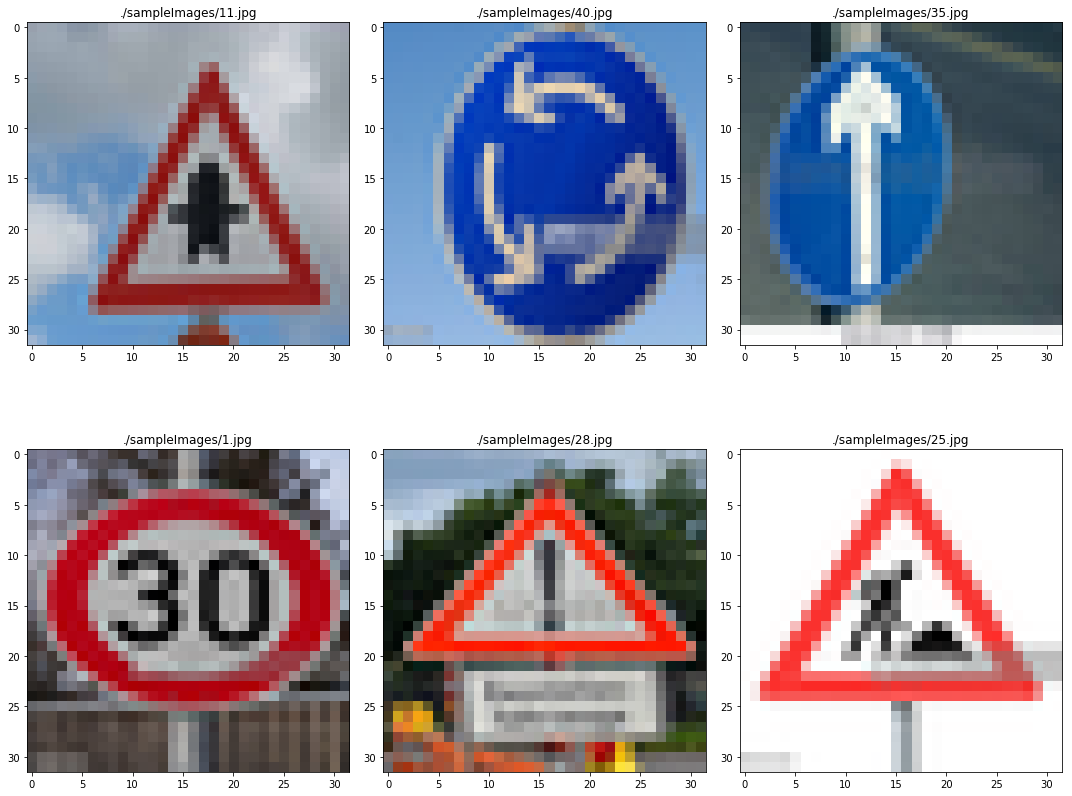

In [26]:
# visualize imgs 
for i in range(len(imgs)):    
    plt.subplot(3, 3, i+1)
    plt.imshow(imgs[i])
    plt.title(imgPaths[i])
    
plt.tight_layout()
plt.show()

### Predict the Sign Type for Each Image

In [27]:
labes = {}
with open ('signnames.csv', 'r') as f:
    i = 0
    for line in f :
        if i == 0:
            i+=1
            continue
        labelIndex, labelStr = line.split(',')
        labes[int(labelIndex)] = labelStr.replace('\n', '')

In [28]:
processed_imgs = processImages(imgs)

with tf.Graph().as_default(), tf.Session() as sess:
    # Instantiate the CNN model
    x, y, keep_prob, logits, optimizer, predictions, accuracy = nn()

    # Load trained weights
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE_PATH)
    
    # Run inference on CNN to make predictions, and remember the logits for later
    res, preds = sess.run([logits, predictions], feed_dict={x: processed_imgs, keep_prob: 1.})

predictLabels = [labes[pred] for pred in preds]

In [29]:
print('Predictions on sample images\n')
trueValue = []
for i in range(len(predictLabels)):
    index = imgPaths[i].split('/')[-1].split('.')[0]
    trueValue.append(int(index))
    print('%s --> %s' % (labes[int(index)], predictLabels[i]))   

Predictions on sample images

Right-of-way at the next intersection --> Right-of-way at the next intersection
Roundabout mandatory --> Roundabout mandatory
Ahead only --> Ahead only
Speed limit (30km/h) --> Speed limit (30km/h)
Children crossing --> General caution
Road work --> Road work


### Analyze Performance

In [30]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Accuracy %8.2f %%"% (np.mean(np.equal(trueValue, preds))*100))

Accuracy    83.33 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

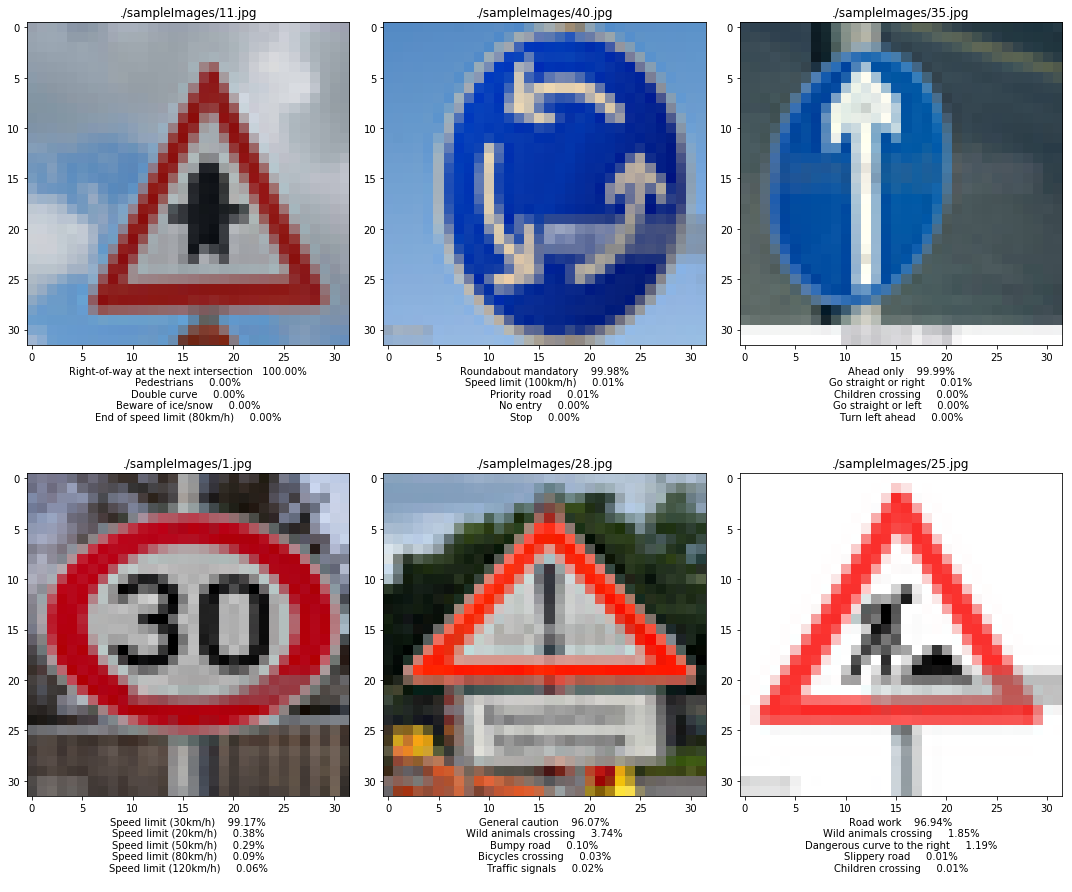

In [31]:
def img_x_labels_with_top_k(values, index):
    top_k_labels = [labes[i] for i in index]
    res = ''
    for i in range(len(index)):
        res += "%s %8.2f%%\n"% (top_k_labels[i], values[i]*100)
    return res

with tf.Graph().as_default(), tf.Session() as sess:    
    y_ = tf.placeholder('float', [None, NUM_CLASSES])
    softmaxResult = tf.nn.softmax(y_)
    val, inx = tf.nn.top_k(softmaxResult, k=5)
    values, index = sess.run([val, inx], feed_dict={y_: res})

for i in range(len(imgs)):    
    plt.subplot(3, 3, i+1)
    plt.imshow(imgs[i])
    plt.title(imgPaths[i])
    plt.xlabel(img_x_labels_with_top_k(values[i], index[i]))
    
plt.tight_layout()
plt.show()

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 